### **Zero-Shot Noise2Noise: Efficient Image Denoising without any Data**


This repository provides a demonstration of how to use our proposed ZS-N2N (Zero-Shot Noise2Noise) algorithm to denoise images without any training data or a noise model or level as input. The notebook is Pytorch based.

The method is as simple as convolving the noisy image with two fixed kernels to create a pair of downsampled images. A simple 2 layer CNN is then trained with a consistency loss to map one downsampled image to the other.

The notebook can easily be run on GPU or CPU. Choose the device to be 'cuda' if you want to run on GPU, otherwise choose 'cpu'. If you choose 'cuda' remember to change your colab runtime to GPU via 'Runtime' -> 'Change runtime type'.



It is recommended to normalize the pixel range of the images to 0-1, as this is the range the hyperparameters and initialization of the network were tested with.

The network's size was optimized for images of size 256x256. If you have smaller or larger images, you might want to decrease or increase the network's size. This can be done by changing the variable "chan_embed".

The 20 test images from SIDD and PolyU can be found here: https://drive.google.com/file/d/1oJ2wIMPAxK353Shz5kW0Xg-KXmwUwYZR/ .
They are normalized and converted to Pytorch tensors, and can be loaded with torch.load('file_name').

In [1]:
#Enter device here, 'cuda' for GPU, and 'cpu' for CPU
device = 'cuda'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [7]:
# Load test image from URL

import requests
from io import BytesIO
import os

proxies = {
'http': 'http://localhost:7890',
'https': 'https://localhost:7890',
}

# 4 test images from the Kodak24 dataset

#url = "https://drive.google.com/uc?export=download&id=18LcKoV4SYusF16wKqwNBJwYpTXE9myie"
#url = "https://drive.google.com/uc?export=download&id=176lM7ONjvyC83GcllCod-j1RPqjLoRoG"
#url = "https://drive.google.com/uc?export=download&id=1UIh9CwXSCf01JmAXgJo0LPtw5TUkWUU-"
url = "https://drive.google.com/uc?export=download&id=1j1OOzvGhet_GHJCaXbfisiW8uGDxI7ty"

# response = requests.get(url,proxies=proxies)
fp = open("00023.00023",'rb')
data = fp.read()
path=BytesIO(data)

clean_img = torch.load(path).unsqueeze(0)
print(clean_img.shape) #B C H W

torch.Size([1, 3, 256, 256])


Add noise to the image

In [9]:
noise_type = 'gauss' # Either 'gauss' or 'poiss'
noise_level = 25     # Pixel range is 0-255 for Gaussian, and 0-1 for Poission

def add_noise(x,noise_level):

    if noise_type == 'gauss':
        noisy = x + torch.normal(0, noise_level/255, x.shape)
        noisy = torch.clamp(noisy,0,1)

    elif noise_type == 'poiss':
        noisy = torch.poisson(noise_level * x)/noise_level

    return noisy

noisy_img = add_noise(clean_img, noise_level)

In [10]:
clean_img = clean_img.to(device)
noisy_img = noisy_img.to(device)

We next define our network, which is a 2 layer CNN

In [11]:
class network(nn.Module):
    def __init__(self,n_chan,chan_embed=48):
        super(network, self).__init__()

        self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.conv1 = nn.Conv2d(n_chan,chan_embed,3,padding=1)
        self.conv2 = nn.Conv2d(chan_embed, chan_embed, 3, padding = 1)
        self.conv3 = nn.Conv2d(chan_embed, n_chan, 1)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.conv3(x)

        return x

n_chan = clean_img.shape[1]
model = network(n_chan)
model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

The number of parameters of the network is:  22275


We next introduce the image pair downsampler which outputs two downsampled images of half the spatial resolution by averaging diagonal pixels in non-overlapping patches, as shown in the below figure.

It is realised by convolving the image with the 2 fixed kernels: $k_1 = \begin{bmatrix}0 & 0.5 \\0.5 & 0\end{bmatrix}$ and $k_2 = \begin{bmatrix}0.5 & 0 \\0 & 0.5\end{bmatrix}$, where the convolution has stride=2, and is applied to each image channel separately.

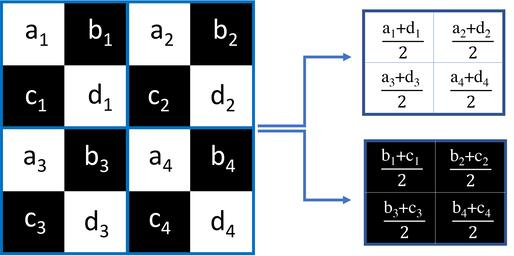

In [12]:
def pair_downsampler(img):
    #img has shape B C H W
    c = img.shape[1]

    filter1 = torch.FloatTensor([[[[0 ,0.5],[0.5, 0]]]]).to(img.device)
    filter1 = filter1.repeat(c,1, 1, 1)

    filter2 = torch.FloatTensor([[[[0.5 ,0],[0, 0.5]]]]).to(img.device)
    filter2 = filter2.repeat(c,1, 1, 1)

    output1 = F.conv2d(img, filter1, stride=2, groups=c)
    output2 = F.conv2d(img, filter2, stride=2, groups=c)

    return output1, output2

Display noisy image and its corresponding downsampled pair. Note how the downsampled images have half the spatial resolution.

Text(0.5, 1.0, 'Second downsampled')

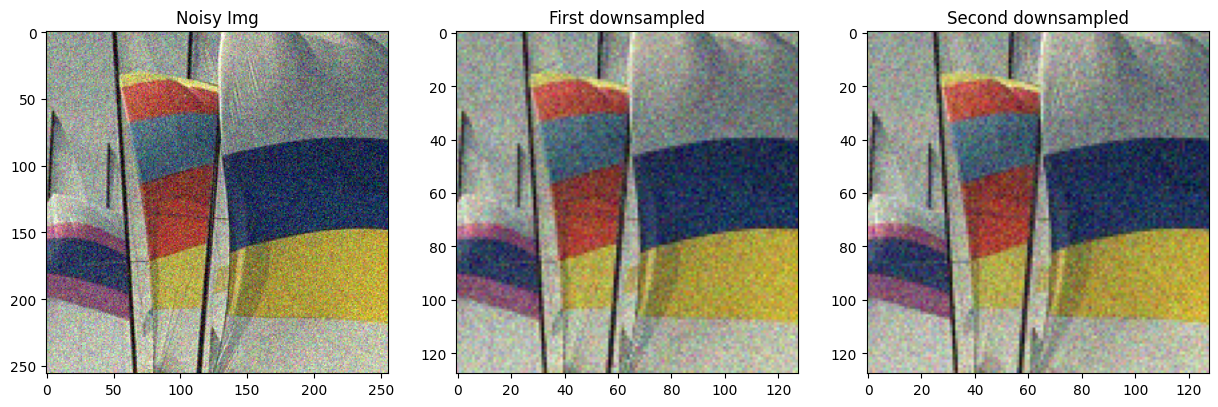

In [13]:
img1, img2 = pair_downsampler(noisy_img)

img0 = noisy_img.cpu().squeeze(0).permute(1,2,0)
img1 = img1.cpu().squeeze(0).permute(1,2,0)
img2 = img2.cpu().squeeze(0).permute(1,2,0)

fig, ax = plt.subplots(1, 3,figsize=(15, 15))

ax[0].imshow(img0)
ax[0].set_title('Noisy Img')

ax[1].imshow(img1)
ax[1].set_title('First downsampled')

ax[2].imshow(img2)
ax[2].set_title('Second downsampled')

The loss function is the sum of a residual loss plus a consistency loss as follows:

$$     \mathcal{L}_\mathrm{res.}(\theta) =\frac{1}{2}\left( \|D_1({y}) - f_{\theta}(D_1({y})) - D_2({y})\|_2^2 + \|D_2({y}) - f_{\theta}(D_2({y})) - D_1({y})\|_2^2 \right). $$

$$     \mathcal{L}_\mathrm{cons.}(\theta) = \frac{1}{2} \left( \|f_{\theta}(D_1({y})) - D_1(f_{\theta}({y}))\|_2^2 + \|f_{\theta}(D_2({y})) - D_2(f_{\theta}({y}))\|_2^2 \right). $$

$$ \mathcal{L}(\theta) = \mathcal{L}_\mathrm{res.}(\theta) + \mathcal{L}_\mathrm{cons.}(\theta), $$

where $y$ is the noisy input image, $D$ is the image pair downsampler, and $f_\theta$ is the network.


In [14]:
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

def loss_func(noisy_img):
    noisy1, noisy2 = pair_downsampler(noisy_img)

    pred1 =  noisy1 - model(noisy1)
    pred2 =  noisy2 - model(noisy2)

    loss_res = 1/2*(mse(noisy1,pred2)+mse(noisy2,pred1))

    noisy_denoised =  noisy_img - model(noisy_img)
    denoised1, denoised2 = pair_downsampler(noisy_denoised)

    loss_cons=1/2*(mse(pred1,denoised1) + mse(pred2,denoised2))

    loss = loss_res + loss_cons

    return loss

Train, test, and denoise functions

In [15]:
def train(model, optimizer, noisy_img):

  loss = loss_func(noisy_img)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item()

def test(model, noisy_img, clean_img):

    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img),0,1)
        MSE = mse(clean_img, pred).item()
        PSNR = 10*np.log10(1/MSE)

    return PSNR

def denoise(model, noisy_img):

    with torch.no_grad():
        pred = torch.clamp( noisy_img - model(noisy_img),0,1)

    return pred

Optimizer and Hyperparameters

In [16]:
max_epoch = 3000     # training epochs
lr = 0.001           # learning rate
step_size = 1000     # number of epochs at which learning rate decays
gamma = 0.5          # factor by which learning rate decays

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Start denoising

In [ ]:
for epoch in tqdm(range(max_epoch)):
    train(model, optimizer, noisy_img)
    scheduler.step()

  0%|          | 0/3000 [00:00<?, ?it/s]

PSNR of denoised image

In [ ]:
PSNR = test(model, noisy_img, clean_img)
print(PSNR)

31.17408216697431


Display clean, noisy, and denoised images.

In [ ]:
denoised_img = denoise(model, noisy_img)

denoised = denoised_img.cpu().squeeze(0).permute(1,2,0)
clean = clean_img.cpu().squeeze(0).permute(1,2,0)
noisy = noisy_img.cpu().squeeze(0).permute(1,2,0)

[Text(0.5, 0, '31.17 dB')]

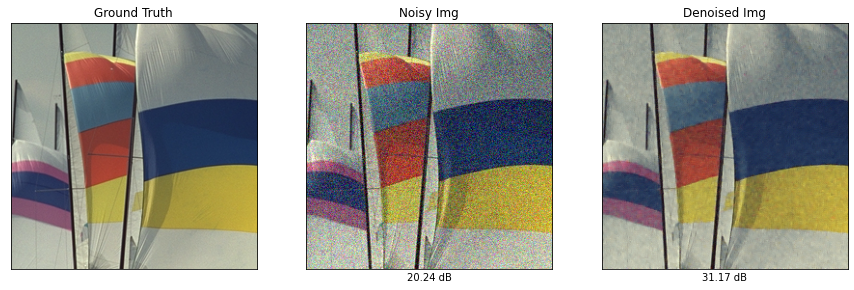

In [ ]:
fig, ax = plt.subplots(1, 3,figsize=(15, 15))

ax[0].imshow(clean)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Ground Truth')

ax[1].imshow(noisy)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Noisy Img')
noisy_psnr = 10*np.log10(1/mse(noisy_img,clean_img).item())
ax[1].set(xlabel= str(round(noisy_psnr,2)) + ' dB')

ax[2].imshow(denoised)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Denoised Img')
ax[2].set(xlabel= str(round(PSNR,2)) + ' dB')